# CS375 - Assignment 2: Shallow bottleneck and sparse shallow bottleneck

In this notebook I implemented the shallow bottleneck and sparse variants and trained them on CIFAR-10. I also trained a shallow bottleneck on the imagenet dataset with poor overall results but much better categorization compared to the models trained on CIFAR.

## ImageNet training and testing

In [1]:
%matplotlib inline 
import os
import numpy as np 
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

In [2]:
from dldata.metrics.utils import compute_metric_base

Can't import separate mcc package
Can't import asgd.
Can't import scikits stuff


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Getting data from the database
Let's connect to the database and pull the data training and test data that is stored while training our network.
In order to find the right experiment id, it is useful to display which experiments are stored in the database first.

In [3]:
# connect to database
dbname = 'final'
collname = 'yolo'
exp_id = 'imagenet'
exp_idc = 'combined_2'
exp_idn = 'combined_nosize'
port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))

[u'in_test', u'imagenet', u'combined', u'combined_fix', u'combined_nosize', u'combined_2', u'imagenet_step150000']


In [4]:
#coll.delete_many({'exp_id':exp_idn})

This shows us all stored experiments. In case you want to delete a particular experiment because you are running out of disk space, you can uncomment and use the following line. You could also just drop the entire collection or even the entire database if you want to get of all of them, but I recommend removing them one by one.

### Plotting the training curve
Now we are interested to see the training curve for exp_id='experiment_1' for example. So the first thing we have to do is to pull the training loss from the database and then we can plot it. I implemented a function that will pull and return the training loss per iteration for you.

Your first task is to take the training loss and plot 1.) the training loss and 2.) a smoothed version of the training loss which you can effectively get by convolving the loss with a vector of ones kernel. You might find the function 'scipy.signal.convolve' useful to solve this task. Experiment with various kernel lengths and describe what you see.

In [4]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

(0, 30)

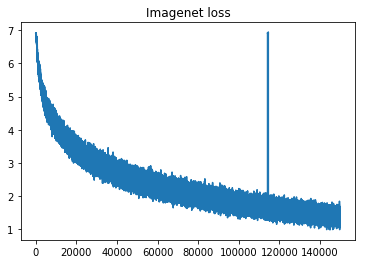

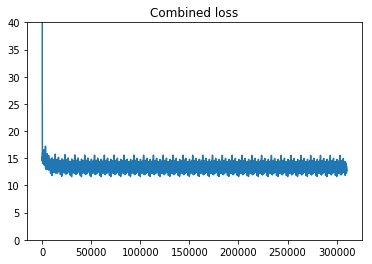

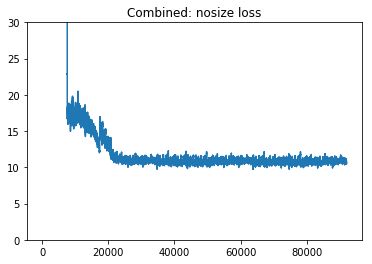

In [5]:

loss = get_losses(coll, exp_id)

lossc = get_losses(coll, exp_idc)

lossn = get_losses(coll, exp_idn)

# Plot the training loss

plt.figure()
plt.title('Imagenet loss')
plt.plot(loss[0:150000])
plt.figure()
plt.title('Combined loss')
plt.plot(smooth_signal(lossc,smooth=100))
plt.ylim((0, 40))
plt.figure()
plt.title('Combined: nosize loss')
plt.plot(smooth_signal(lossn,smooth=100))
plt.ylim((0,30))

We found that all three models were able to be trained on CIFAR-10 and we were also able to train a model on imagenet. Loss functions bottomed out very suddenly with very few epochs.

### Plotting the validation results
After our train_imagenet function has evaluated the Image Net validation set for the time we can have a look at the validation results of for example exp_id='experiment_1'. Again, you need to pull the validation data from the database first. The validation data consists of the top1 and top5 accuracy that you have implemented previously. 

We have provided a function that pulls the necessary data from the database. Your task is to plot the validation curve of the top1 and top5 accuracy. Label the graphs respectively and describe what you see.

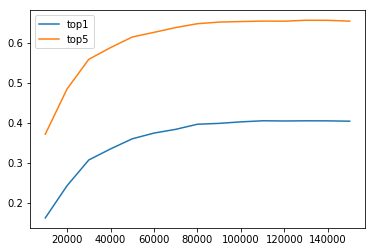

In [53]:
def get_validation_data(coll, exp_id):
    """
    Gets the validation data from the database (except for gridfs data)
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'step'])
    top1 = [val_steps[i]['validation_results']['topn_val']['top1'] 
            for i in range(val_steps.count())]
    top5 = [val_steps[i]['validation_results']['topn_val']['top5'] 
            for i in range(val_steps.count())]
    steps = [val_steps[i]['step'] for i in range(val_steps.count())]
    return top1, top5, steps

top1, top5, steps = get_validation_data(coll, exp_id)
#top1c, top5c, stepsc = get_validation_data(coll, exp_idc)
### PLOT VALIDATION RESULTS HERE
plt.plot(steps, top1, label='top1')
#plt.plot(steps, top1, label='top1c')
plt.plot(steps, top5, label='top5')
#plt.plot(steps, top1, label='top5c')
plt.legend()

In [52]:
top5c

[]

## Neural analysis
Now let's move on to fetching and displaying the computations and tests that you ran in the neural_analysis agg_func. We will first pull the data which was stored in the validation results in the database. Therefore, we call the function 'get_neural_validation_data'. The returned 'validation_data' is a list of dictionaries that contain your validation results. It's keys contain amongst others the 'exp_id' of your experiment, the evaluated 'step', and the actual 'validation_results'. In part 2 of this assignment, you should have evaluated your model at different iteration steps.

In the following, your task will be to plot your evaluations at different iteration steps. Therefore, index the data list with the appropriate indices, plot the results and mark all of the following plots with the iteration step.

In [57]:
def get_neural_validation_data(coll,exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])
    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

vd = get_neural_validation_data(coll,exp_id=exp_id)
vdc = get_neural_validation_data(coll,exp_id=exp_idc)
print('data keys:')
print(vd[1]['validation_results'].keys())
print(vdc[0]['validation_results'].keys())

data keys:
[u'V6', u'VAll']
[u'V6', u'VAll']


In [58]:
"""
You will need to EDIT this part.
Please subselect 'validation_data' with 'idx' to pick the data entry for your desired iteration step.
1.) Assign 
    data = 'validation_data[idx]['validation_results']['valid0']'
and
    step = validation_data[idx]['step']
2.) Choose the target_layers you want to evaluate on.
"""
target_layers = ['conv_1','conv_2','conv_3','conv_4','conv_5','conv_6','conv_7','conv_8','conv_9','fc1',
                         'fc2']
idx = 1 ### YOUR idx HERE
data_all = vd[idx]['validation_results']['VAll']
data_6 = vd[idx]['validation_results']['V6']
step = vd[idx]['step']

idxc = 0
data_allc = vdc[idxc]['validation_results']['VAll']
data_6c = vdc[idxc]['validation_results']['V6']
stepc = vdc[idxc]['step']

### Analyzing the regression results

We will now display the results of the regression test. 

Please print (1 - data['it\_regression_"insert_target_layer_here"']['noise_corrected_multi_rsquared_loss']) for each layer and step and label the print out with the layer name and step. Describe what you observe.

********** V 6 *********************


([<matplotlib.axis.XTick at 0x7fbd8ea65510>,
 <a list of 11 Text xticklabel objects>)

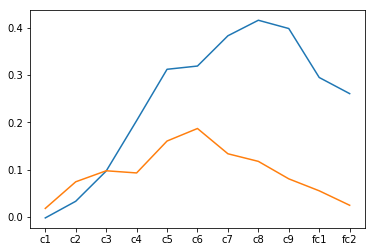

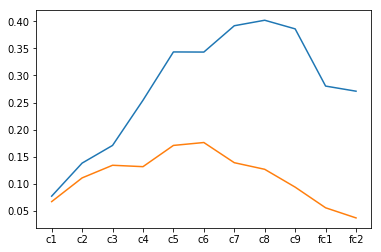

In [61]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    perf = []
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['noise_corrected_multi_rsquared_loss']
        perf.append(performance)
        #print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE
    return(perf)
        
print('********** V 6 *********************')
p6 = plot_regression_results(data_6, target_layers, step)
pall = plot_regression_results(data_all, target_layers, step)
p6c = plot_regression_results(data_6c, target_layers, stepc)
pallc = plot_regression_results(data_allc, target_layers, stepc)

plt.figure()
plt.plot(p6)
plt.plot(p6c)
plt.xticks(np.arange(11),('c1','c2','c3','c4','c5','c6','c7','c8','c9','fc1','fc2'))

plt.figure()
plt.plot(pall)
plt.plot(pallc)
plt.xticks(np.arange(11),('c1','c2','c3','c4','c5','c6','c7','c8','c9','fc1','fc2'))

The autoencoder wasn't able to successfully do regression in any case. 

In [72]:

def plot_imagenet_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    for i, layer in enumerate(target_layers):
        k = 'imagenet_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        labels = categorization_results['labelset']
        acc = 2*(np.mean(categorization_results['accbal'])-0.5)
        print('{name}: avg_accuracy: {acc:.5f}; step: {step}'.format(
            name=layer,
            acc=acc,
            step=step,
        ))
    